In [178]:
import pandas as pd
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import string 
import warnings
warnings.simplefilter('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from regressors import stats
from sklearn.feature_selection import chi2

In [179]:
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier

# Lecture 2
from sklearn.model_selection import train_test_split 

# Lecture 3
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

# Lecture 4
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OneHotEncoder

# Lecture 5
from sklearn.linear_model import LogisticRegression, LinearRegression

# Lecture 6
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

# Lecture 7
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Lecture 8
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
import numpy as np
import pandas as pd
import pickle 

import graphviz

from sklearn import datasets
from sklearn.datasets import make_blobs, make_hastie_10_2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option("display.max_colwidth", 200)

import altair as alt
import time

# pip install ipython-autotime
import autotime

In [180]:
def show_scores(model, 
                X_train, y_train,
                X_valid, y_valid):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        None
        prints the train and validation errors. 
            
    """    
    print("Training error:   %.2f" % (1-model.score(X_train, y_train)))
    print("Validation error: %.2f" % (1-model.score(X_valid, y_valid)))

In [181]:
def get_scores(model, 
                X_train, y_train,
                X_valid, y_valid, 
                show = True
               ):
    """
    Returns train and validation error given a model
    train and validation X and y portions
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray        
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set    
    X_valid: numpy.ndarray        
        The X part of the validation set
    y_valid: numpy.ndarray
        The y part of the validation set    
    Returns
    -------
        train_err: float
        test_err: float
            
    """    
    if show: 
        print("Training error:   %.2f" % (1-model.score(X_train, y_train)))
        print("Validation error: %.2f" % (1-model.score(X_valid, y_valid)))
        print('\n')
    return (1-model.score(X_train, y_train)), (1-model.score(X_valid, y_valid))

In [182]:
def show_sig(num):
    if num < 0.001:
        return "***"
    elif num < 0.01:
        return "**"
    elif num < 0.05:
        return "*"
    else:
        return ""

In [70]:
# Load dataset 
train_original = pd.read_csv("../data/train_dataset.csv")
test_original = pd.read_csv("../data/test_dataset.csv")
resume_original = pd.read_csv("../data/05182020_cleaned_english_resumes_V1.0.csv")
avg_work = pd.read_csv("../result/avg_work_exp.csv")
competitor = pd.read_csv("../result/competitor_experience.csv")
education_concentration = pd.read_csv("../data/education_concentration.csv")
work_title = pd.read_csv("../data/work_title.csv")
degree = pd.read_csv("../data/features_edu_01_training_df.csv")

In [71]:
education_concentration.drop_duplicates("employee_code", inplace=True)
work_title.drop_duplicates("employee_code", inplace=True)
degree.drop_duplicates("employee_code", inplace=True)


education_concentration.rename(columns={'blue collar':'blue collar_concentration', 
                                        'education': 'education_concentration', 
                                        'other':'other_concentration'}, inplace=True)

work_title.rename(columns={'blue collar':'blue collar_work', 
                                        'education': 'education_work', 
                                        'other':'other_work'}, inplace=True)

In [72]:
# Prepare train and test datasets
train = pd.merge(train_original, resume_original, how="left", on="employee_code").merge(
                                     avg_work, how="left", on="employee_code").merge(
                                     competitor, how="left", on="employee_code").merge(
                                    education_concentration, how="left", on="employee_code").merge(
                                    work_title, how = "left", on="employee_code").merge(
                                    degree, how="left", on="employee_code")


#[["employee_code", "raw_resume", "resume_text", "resume_bline", "clean_text", "job_hopper", "competitor_experience", "hp_class"]]

#test = pd.merge(test_original, resume_original, how="left", on="employee_code"
#               )[["employee_code", "raw_resume", "resume_text", "resume_bline", "clean_text", "hp_class"]]
#X_train = train["clean_text"]
#y_train = train["hp_class"]
#X_test = test["clean_text"]
#y_test = test["hp_class"]

In [75]:
degree.columns

Index(['Unnamed: 0', 'employee_code', 'highest_degree',
       'background_highest_degree', 'country_highest_degree'],
      dtype='object')

In [77]:
train = train[["employee_code", 'termination_type', 'rehired_', 'referral_flag', "raw_resume",
       "resume_text", "resume_bline", "clean_text", "job_hopper", "competitor_experience", 'accounting', 'arts',
       'audio technician', 'blue collar_concentration', 'business',
       'communication', 'computer systems', 'criminology', 'dental',
       'economics', 'education_concentration', 'engineering', 'english',
       'finance', 'general', 'healthcare', 'hospitality', 'human resource',
       'interactive arts and technology', 'kinesiology', 'law', 'marketing',
       'no education', 'other_concentration', 'physics', 'psychology',
       'science', 'sociology', 'statistics', 'administrative', 'assistant manager', 'blue collar_work', 'cashier',
       'cook', 'customer service representative', 'driver', 'education_work',
       'financial services', 'fitness/sports', 'manager', 'no work',
       'other_work', 'sales associate', 'technicians', 'telemarketers', 'highest_degree',
       'background_highest_degree', 'country_highest_degree', 'hp_class']]

# Pre-feature engineering
After comparing unigram and bigram and trigrams, we found bigrams make more sense to resumes.

So here we are going to see which bigrams is significant, then we will consider those bigrams counts as features in our model

In [23]:
vec = CountVectorizer(max_features=5000, ngram_range=(2, 2))
X_train_counts = vec.fit_transform(X_train) 
X_test_counts = vec.transform(X_test)

In [24]:
lr = LogisticRegression()
lr.fit(X_train_counts, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
# Get features (words in our case)
vocab = vec.get_feature_names()
weights = lr.coef_.flatten()
scores, pvalues = chi2(X_train_counts, y_train)

# Sort the coefficients in descending order 
inds = np.argsort(lr.coef_.flatten())

# pick the first 20 as most informative features for negative reviews  
negative_words = [vocab[index] for index in inds[:20]]

# pick the last 20 features as most informative features for positive reviews  
positive_words = [vocab[index] for index in inds[-20:][::-1]]

neg_words_weights = [(weights[index]) for index in inds[:20]]
pos_words_weights = [(weights[index]) for index in inds[-20:][::-1]]

neg_words_pvalues = [(pvalues[index]) for index in inds[:20]]
pos_words_pvalues = [(pvalues[index]) for index in inds[-20:][::-1]]

df = pd.DataFrame({'Neg feats':negative_words, 'Neg weights':neg_words_weights, "Neg pvalues": neg_words_pvalues, 
                   'Pos feats':positive_words, 'Pos weights':pos_words_weights, "Pos pvalues": pos_words_pvalues})
df["Neg sig."] = df["Neg pvalues"].apply(show_sig)
df["Pos sig."] = df["Pos pvalues"].apply(show_sig)
df[['Neg feats', 'Neg weights', 'Neg pvalues', 'Neg sig.', 'Pos feats', 'Pos weights', 'Pos pvalues', 'Pos sig.']]

,Neg feats,Neg weights,Neg pvalues,Neg sig.,Pos feats,Pos weights,Pos pvalues,Pos sig.
0,high school,-0.513144,0.014402,*,efficient service,0.440615,0.000079,***
1,sale associate,-0.467281,0.085937,,rogers communications,0.418416,0.005993,**
2,team player,-0.426519,0.219790,,work ethic,0.382055,0.248989,
3,health safety,-0.355103,0.019471,*,sale closing,0.373974,0.000416,***
4,excellent service,-0.307044,0.254905,,university fraser,0.357177,0.000015,***
5,cash register,-0.296875,0.045346,*,sale target,0.352404,0.041786,*
6,ms office,-0.295314,0.284395,,university england,0.336289,0.002239,**
7,food prep,-0.289780,0.060191,,marketing business,0.335721,0.413257,
8,project management,-0.272953,0.049651,*,support technician,0.328337,0.002239,**
9,time management,-0.261679,0.474262,,sale representative,0.325761,0.130210,


In [26]:
X_train_count_df = pd.DataFrame(columns=vec.get_feature_names(), data=X_train_counts.todense())
X_train_count_df[["efficient service", "mobile expert", "high school", "information system", "cash register", "high school"]]

,efficient service,mobile expert,high school,information system,cash register,high school
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
283,0,0,1,0,0,1
284,0,0,1,0,0,1
285,0,0,0,0,1,0
286,0,0,0,0,0,0


In [188]:
# save word counts
counts = X_train_count_df[["efficient service", "mobile expert", "high school", "information system", "cash register"]]

In [191]:
counts["employee_code"] = train.employee_code

In [192]:
counts.to_csv("../data/word_counts.csv", index=False)

In [193]:
train.columns

Index(['employee_code', 'termination_type', 'rehired_', 'referral_flag',
       'raw_resume', 'resume_text', 'resume_bline', 'clean_text', 'job_hopper',
       'competitor_experience', 'accounting', 'arts', 'audio technician',
       'blue collar_concentration', 'business', 'communication',
       'computer systems', 'criminology', 'dental', 'economics',
       'education_concentration', 'engineering', 'english', 'finance',
       'general', 'healthcare', 'hospitality', 'human resource',
       'interactive arts and technology', 'kinesiology', 'law', 'marketing',
       'no education', 'other_concentration', 'physics', 'psychology',
       'science', 'sociology', 'statistics', 'administrative',
       'assistant manager', 'blue collar_work', 'cashier', 'cook',
       'customer service representative', 'driver', 'education_work',
       'financial services', 'fitness/sports', 'manager', 'no work',
       'other_work', 'sales associate', 'technicians', 'telemarketers',
       'highest_de

In [28]:
train2 = pd.concat([X_train_count_df[["efficient service", "mobile expert", "high school", "information system", "cash register"]], 
          train[["job_hopper", "competitor_experience", "hp_class"]]], axis=1)
train3 = pd.concat([education_concentration, train2], axis=1)

In [ ]:
train3

In [22]:
train2.hp_class.value_counts()

0.0    218
1.0     70
Name: hp_class, dtype: int64

### Start pipeline 

In [89]:
train2 = train.copy()
train2.referral_flag = X_train.referral_flag.fillna(0)

In [177]:
train2.to_csv("../data/0528_training_dataset.csv", index=False)

### step 1: 

In [165]:
X_train2 = train2.drop(columns=["hp_class"])
y_train2 = train2["hp_class"]
X_train, X_valid, y_train, y_valid = train_test_split(X_train2, y_train2, 
                                                         train_size=0.75, random_state=22)

In [166]:
X_train.shape, X_valid.shape # or maybe not, we can do cross validation instead 

((216, 58), (72, 58))

In [167]:
numeric_features =['referral_flag', 'job_hopper', 'competitor_experience','accounting', 'arts', 'audio technician',
       'blue collar_concentration', 'business', 'communication',
       'computer systems', 'criminology', 'dental', 'economics',
       'education_concentration', 'engineering', 'english', 'finance',
       'general', 'healthcare', 'hospitality', 'human resource',
       'interactive arts and technology', 'kinesiology', 'law', 'marketing',
       'no education', 'other_concentration', 'physics', 'psychology',
       'science', 'sociology', 'statistics', 'administrative',
       'assistant manager', 'blue collar_work', 'cashier', 'cook',
       'customer service representative', 'driver', 'education_work',
       'financial services', 'fitness/sports', 'manager', 'no work',
       'other_work', 'sales associate', 'technicians', 'telemarketers']
categorical_features = ['highest_degree', 'background_highest_degree', 'country_highest_degree']

In [168]:
numeric_transformer = Pipeline(steps=[
                                      ('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())
                                    ])


categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='constant', 
                                                                    fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

preprocessor = ColumnTransformer(
                                 transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ('cat', categorical_transformer, categorical_features)
                                ])

In [169]:
models = {
          'decision tree': DecisionTreeClassifier(class_weight="balanced"),
          'kNN': KNeighborsClassifier(),
          'logistic regression': LogisticRegression(class_weight = "balanced"),
          'RBF SVM' : SVC(class_weight = "balanced"), 
          'random forest' : RandomForestClassifier(class_weight = "balanced"), 
          'xgboost' : XGBClassifier(class_weight = "balanced"),
          'lgbm': LGBMClassifier(class_weight = "balanced")
         }

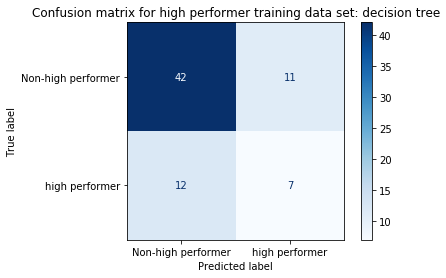

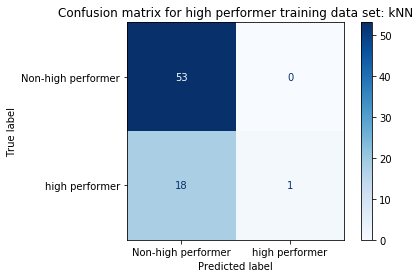

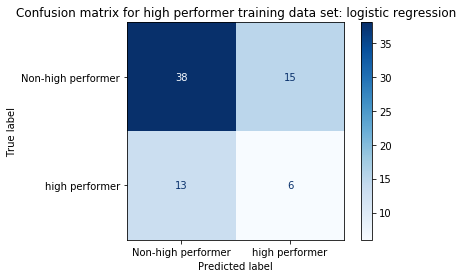

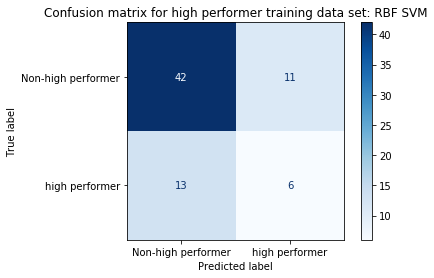

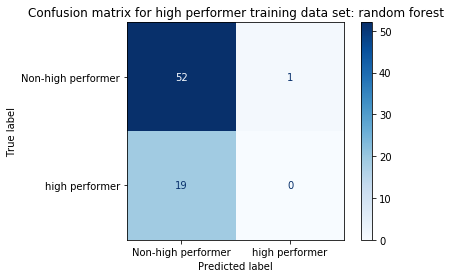

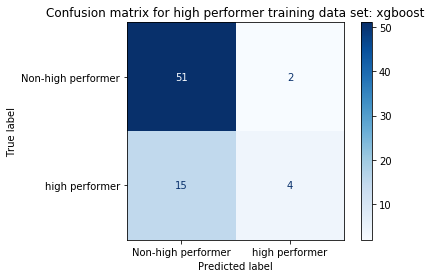

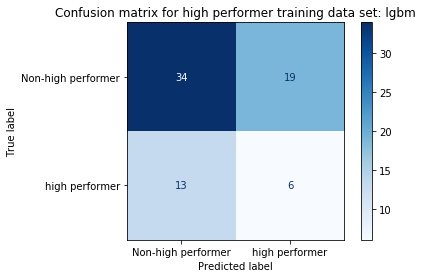

In [170]:
results_dict = {}
for model_name, model in models.items(): 
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train.to_numpy().ravel());
    tr_err, valid_err = get_scores(clf, X_train, y_train, 
                                   X_valid, y_valid, show = False)
    y_valid_pred = clf.predict(X_valid)
    recall = recall_score(y_valid, y_valid_pred)
    results_dict[model_name] = [round(tr_err,3), round(valid_err,3), round(recall, 3)]
    disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
    disp.ax_.set_title('Confusion matrix for high performer training data set: '+model_name)

In [171]:
results_df = pd.DataFrame(results_dict).T
results_df.columns = ["Train error", "Validation error", "recall"]
results_df

,Train error,Validation error,recall
decision tree,0.000,0.319,0.368
kNN,0.208,0.250,0.053
logistic regression,0.194,0.389,0.316
RBF SVM,0.120,0.333,0.316
random forest,0.000,0.278,0.000
xgboost,0.134,0.236,0.211
lgbm,0.139,0.444,0.316


In [144]:
opt_dict = {} # used to collect rmse for the best case of each model
df = pd.DataFrame(y_valid).copy() # used to collect obeserved and predicted values

def opt(model_name, model, grid):
    """
    calculate optimized test error (rmse) given a model
    train and test X and y splits after optimizing 
    by changing hyperparameters
    
    Parameters
    ----------
    model_name: str
        A string to be used as model name 
    model: sklearn classifier model
        The sklearn model
    grid: dict       
        A Dict used to store hyperparameters 
    """   
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train.to_numpy().ravel());
    grid_search = GridSearchCV(clf, grid, cv = 5, scoring="f1")
    grid_result = grid_search.fit(X_train, y_train)
    print("Best param is: ", grid_result.best_params_)
    tr_err, valid_err = get_scores(grid_result, X_train, y_train, 
                                   X_valid, y_valid, show = False)
    y_valid_pred = grid_search.predict(X_valid)
    recall = recall_score(y_valid, y_valid_pred)
    results_dict[model_name] = [round(tr_err,3), round(valid_err,3), round(recall, 3)]
    disp = plot_confusion_matrix(grid_result, X_valid, y_valid,
                             display_labels=['Non-high performer', 'high performer'],
                             cmap=plt.cm.Blues, 
                             values_format = 'd')
    disp.ax_.set_title('Confusion matrix for high performer training data set: '+model_name)

In [ ]:
weights = np.linspace(0.05, 0.95, 20)
lg_param_grid = {"preprocessor__num__imputer__strategy": ['mean', 'median'],
                "classifier__C": [0.9, 1.0],
                'classifier__class_weight': [{0: x, 1: 1.0-x} for x in weights]
                }
#svr_param_grid = {"preprocessor__num__imputer__strategy": ['mean', 'median'],
#                  "classifier__gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
#knr_param_grid = {"preprocessor__num__imputer__strategy": ['mean', 'median'],
#                  "classifier__n_neighbors": list(range(1,50,1))}
rf_param_grid = {"preprocessor__num__imputer__strategy": ['mean', 'median'],
                  "classifier__max_depth": list(range(1,50,1)),
                  'classifier__class_weight': [{0: x, 1: 1.0-x} for x in weights]}

opt('logistic regression', LogisticRegression(), lg_param_grid)
#opt('svr', SVR(gamma = "auto"), svr_param_grid)
#opt('kneighbor regressor', KNeighborsRegressor(), knr_param_grid)
opt('random forest', RandomForestClassifier(), rf_param_grid)

--- 
## Feature selection: FRE 